# BigBasket Product Categorization

## 1. Project overview
This is the final project for DTSA 5510 (Unsupervised Algorithms in Machine Learning). [GitHub repository](https://github.com/SharronX/DTSA-5510-Final-Project)

### About the data
The data I used is from [Kaggle](https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints).  It contains product information from an Indian online grocery supermarket called BigBasket.

### Objective
In this project, supposing that a new product is launched online, we would like to correctly classify it into a specific category so that we can better recommend the product to users with corresponding needs. To do this, I will first apply word embedding methods to generate a feature matrix and then use unsupervised machine learning methods to classify the products. In addition, I will also apply some supervised machine learning methods on the same dataset and compare their performance.

## 2. Exploratory Data Analysis (EDA) 

### Data inspection
The dataset contains 27554 samples and 10 attributes, which are defined as follows.
| Attribute | Definition |
| :----------- | :----------- |
| index | Simply the Index |
| product | Title of the product (as they're listed) |
| category | Category into which product has been classified |
| sub_category | Subcategory into which product has been kep |
| brand | Brand of the product |
| sale_price | Price at which product is being sold on the site |
| market_price | Market price of the product  |
| type | Type into which product falls |
| rating | Rating the product has got from its consumers |
| description | Description of the dataset (in detail) |

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/BigBasket Products.csv')

In [3]:
df

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.00,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.00,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.00,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.00,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.00,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...
...,...,...,...,...,...,...,...,...,...,...
27550,27551,"Wottagirl! Perfume Spray - Heaven, Classic",Beauty & Hygiene,Fragrances & Deos,Layerr,199.20,249.0,Perfume,3.9,Layerr brings you Wottagirl Classic fragrant b...
27551,27552,Rosemary,Gourmet & World Food,Cooking & Baking Needs,Puramate,67.50,75.0,"Herbs, Seasonings & Rubs",4.0,Puramate rosemary is enough to transform a dis...
27552,27553,Peri-Peri Sweet Potato Chips,Gourmet & World Food,"Snacks, Dry Fruits, Nuts",FabBox,200.00,200.0,Nachos & Chips,3.8,We have taken the richness of Sweet Potatoes (...
27553,27554,Green Tea - Pure Original,Beverages,Tea,Tetley,396.00,495.0,Tea Bags,4.2,"Tetley Green Tea with its refreshing pure, ori..."


In [4]:
df["category"].unique()

array(['Beauty & Hygiene', 'Kitchen, Garden & Pets',
       'Cleaning & Household', 'Gourmet & World Food',
       'Foodgrains, Oil & Masala', 'Snacks & Branded Foods', 'Beverages',
       'Bakery, Cakes & Dairy', 'Baby Care', 'Fruits & Vegetables',
       'Eggs, Meat & Fish'], dtype=object)

### Data Cleaning

In [5]:
# Combine product name & description
# Drop null value
df['product_description'] = df['product'].astype(str)+ ". "+df["description"].astype(str)
df = df.dropna(subset=['category', 'product_description'])
df

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description,product_description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.00,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...,Garlic Oil - Vegetarian Capsule 500 mg. This P...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.00,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ...",Water Bottle - Orange. Each product is microwa...
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.00,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m...","Brass Angle Deep - Plain, No.2. A perfect gift..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.00,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...,Cereal Flip Lid Container/Storage Jar - Assort...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.00,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...,Creme Soft Soap - For Hands & Body. Nivea Crem...
...,...,...,...,...,...,...,...,...,...,...,...
27550,27551,"Wottagirl! Perfume Spray - Heaven, Classic",Beauty & Hygiene,Fragrances & Deos,Layerr,199.20,249.0,Perfume,3.9,Layerr brings you Wottagirl Classic fragrant b...,"Wottagirl! Perfume Spray - Heaven, Classic. La..."
27551,27552,Rosemary,Gourmet & World Food,Cooking & Baking Needs,Puramate,67.50,75.0,"Herbs, Seasonings & Rubs",4.0,Puramate rosemary is enough to transform a dis...,Rosemary. Puramate rosemary is enough to trans...
27552,27553,Peri-Peri Sweet Potato Chips,Gourmet & World Food,"Snacks, Dry Fruits, Nuts",FabBox,200.00,200.0,Nachos & Chips,3.8,We have taken the richness of Sweet Potatoes (...,Peri-Peri Sweet Potato Chips. We have taken th...
27553,27554,Green Tea - Pure Original,Beverages,Tea,Tetley,396.00,495.0,Tea Bags,4.2,"Tetley Green Tea with its refreshing pure, ori...",Green Tea - Pure Original. Tetley Green Tea wi...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                27555 non-null  int64  
 1   product              27554 non-null  object 
 2   category             27555 non-null  object 
 3   sub_category         27555 non-null  object 
 4   brand                27554 non-null  object 
 5   sale_price           27555 non-null  float64
 6   market_price         27555 non-null  float64
 7   type                 27555 non-null  object 
 8   rating               18929 non-null  float64
 9   description          27440 non-null  object 
 10  product_description  27555 non-null  object 
dtypes: float64(3), int64(1), object(7)
memory usage: 2.3+ MB


#### Data Cleaning Summary
Under our assumption, when we got a new product, we do not know its type or rating yet. All we got is the product name and its description. So we combine these two attributes to a new "product_description" attribute for word embedding. Also we make sure there are no null value.

### Data Visualization

Text(0.5, 1.0, 'Histogram of category')

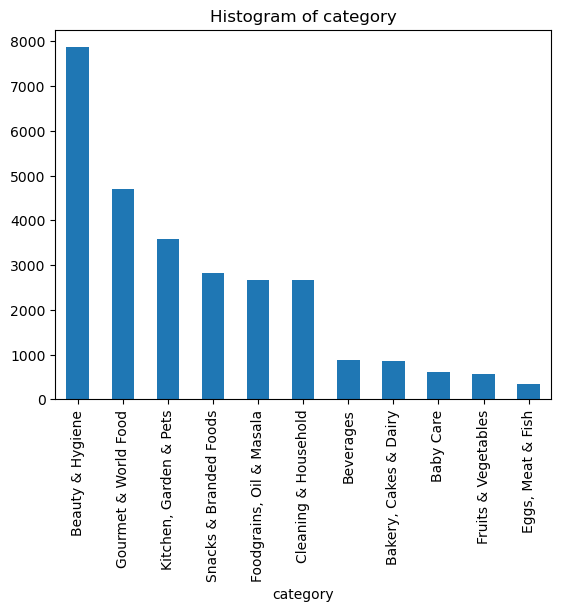

In [7]:
# Histogram of category
df['category'].value_counts().plot(kind='bar')
plt.title('Histogram of category') 

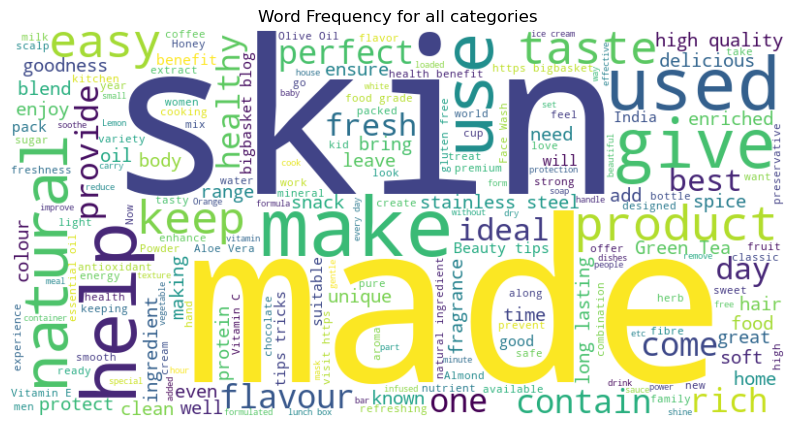

In [8]:
# Word frequency for all categories

from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

all_text = ' '.join(df['product_description'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency for all categories')
plt.show()

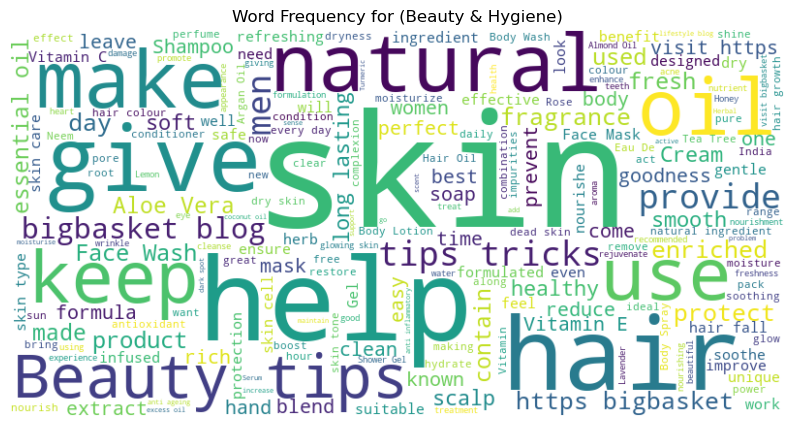

In [9]:
# Word frequency for 'Beauty & Hygiene' category

beautyHygiene_text = ' '.join(df[df['category']=='Beauty & Hygiene']['product_description'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(beautyHygiene_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency for (Beauty & Hygiene)')
plt.show()

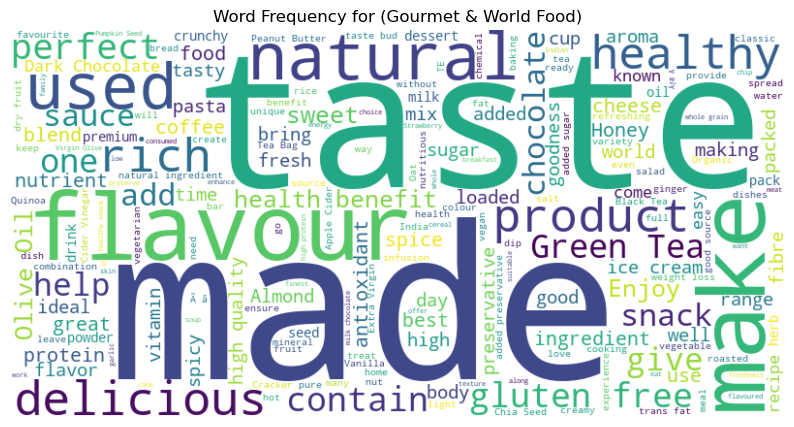

In [10]:
# Word frequency for 'Gourmet & World Food' category

gourmet_text = ' '.join(df[df['category']=='Gourmet & World Food']['product_description'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(gourmet_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Frequency for (Gourmet & World Food)')
plt.show()

### Data Preparation

In [11]:
# Word embedding

f = df["product_description"].replace("\n", " ")
 
def prepare_corpus(df_Text):
    output = []
    
    # iterate through each sentence in the file

    for ind, t in df_Text.items():
        temp = []
        for i in sent_tokenize(t):        

            # tokenize the sentence into words
            for j in word_tokenize(i):
                temp.append(j.lower())

        output.append(TaggedDocument(temp, [ind]))
    return output

# vector_size=100
vector_size=500
model = Doc2Vec(prepare_corpus(f), min_count=1, vector_size=vector_size, window=5, workers=8)

In [12]:
embeddings = np.zeros((len(df), vector_size))
for i in range(len(df)):
    embeddings[i,:] = model.dv[i]

In [13]:
embeddings.shape

(27555, 500)

In [14]:
# Split data into train set and test set

X = embeddings

le = LabelEncoder()
le.fit(df['category'])
y = le.transform(df['category'])
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)
for train_ind, test_ind in sss.split(X, y):
    X_train, X_test, y_train, y_test = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

In [15]:
print (np.histogram(y_train,density=True))
print (np.histogram(y_test,density=True))

(array([0.02213754, 0.03089276, 0.28547451, 0.03211758, 0.09707857,
       0.01270187, 0.09712393, 0.02023226, 0.17020504, 0.23203593]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))
(array([0.02213754, 0.0308474 , 0.2856106 , 0.03211758, 0.09707857,
       0.01270187, 0.09707857, 0.02014154, 0.17020504, 0.23208129]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))


### Exploratory Data Analysis (EDA) summary
- From the category histogram and word frequency statistics, we found that the data is not well balanced: some categories (such as "Beauty and Hygiene") have more data than other categories. And the product description word frequency of these categories with large data volume significantly affects the word frequency of the overall data. We need to take this into account when training the model.
- I used Doc2Vec to embed "product_description" and got a matrix of shape 27555 * 500.
- The data was split into 80% training set and 20% testing set to compare the performance of unsupervised and supervised learning methods.

## 3. Unsupervised Learning Models

### a) Hierarchical Clustering Model

In [16]:
# Build hierarchical clustering model with n_clusters=11

start = time.time()

hierarchical_model = AgglomerativeClustering(n_clusters=len(le.classes_), metric='cosine', linkage='average')
hierarchical_model.fit(X)
hierarchical_model.labels_

end = time.time()
print("[Hierarchical Clustering] The running time is: ", end-start, "seconds")

[Hierarchical Clustering] The running time is:  220.4479215145111 seconds


In [17]:
# Find the best match between cluster index number and category name

def category_matching(ytdf,yp, cluster_category, permutation_list):
    acc = 0
    categoryorder = {}
    for permutation in permutation_list:
        category_df = ytdf
        category_map = dict(zip(cluster_category, permutation))
        accuracy = accuracy_score(y_true = category_df['category'].map(category_map), y_pred = yp)
        if(accuracy > acc):
            acc = accuracy
            categoryorder = category_map
    
    return categoryorder, acc

In [18]:
# Compute the runing time of finding the best matching for hierarchical model

cluster_category = df["category"].unique()
category_permutations = list(itertools.permutations(list(range(len(cluster_category))) ))

# split to 4 cpus
permutation_list_1 = category_permutations[0:int(0.25*len(category_permutations))]
permutation_list_2 = category_permutations[int(0.25*len(category_permutations)): int(0.5*len(category_permutations))]
permutation_list_3 = category_permutations[int(0.5*len(category_permutations)): int(0.75*len(category_permutations))]
permutation_list_4 = category_permutations[int(0.75*len(category_permutations)):]

start = time.time()

from joblib import Parallel, delayed
runs = Parallel(n_jobs=4)(delayed(category_matching)(pd.DataFrame({'category': le.inverse_transform(y_train)}), 
                                                     hierarchical_model.labels_[train_ind],
                                                     cluster_category,
                                                     i) for i in [permutation_list_1, permutation_list_2, permutation_list_3, permutation_list_4])
end = time.time()
print("[Hierarchical Clustering] The running time for maximizing accuracy for cluster assignments: ", end-start, "seconds")

[Hierarchical Clustering] The running time for maximizing accuracy for cluster assignments:  52326.514307022095 seconds


#### Train accuracy for Hierarchical Clustering

In [19]:
# train accuracy and the best match between cluster index number and category name

acc = 0
categoryorder = {}

for r in runs:
    _categoryorder, _acc = r
    if _acc > acc:
        categoryorder = _categoryorder
        acc = _acc
print ("[Hierarchical Clustering] The best matching of category name & clustering is:", categoryorder)
print ("[Hierarchical Clustering] The train accuracy is:", acc)

[Hierarchical Clustering] The best matching of category name & clustering is: {'Beauty & Hygiene': 1, 'Kitchen, Garden & Pets': 5, 'Cleaning & Household': 4, 'Gourmet & World Food': 2, 'Foodgrains, Oil & Masala': 7, 'Snacks & Branded Foods': 3, 'Beverages': 8, 'Bakery, Cakes & Dairy': 0, 'Baby Care': 6, 'Fruits & Vegetables': 9, 'Eggs, Meat & Fish': 10}
[Hierarchical Clustering] The train accuracy is: 0.28597350753039374


#### Test accuracy for Hierarchical Clustering

In [20]:
# test accuracy

print ("[Hierarchical Clustering] The test accuracy is:", accuracy_score(y_true = (pd.DataFrame({'category': le.inverse_transform(y_test)}))['category'].map(categoryorder), y_pred = hierarchical_model.labels_[test_ind]))

[Hierarchical Clustering] The test accuracy is: 0.28651787334422063


### b) K-means Clustering Model

In [21]:
# Build kmeans clustering model and compute the running time

start = time.time()
kmeans = KMeans(n_clusters=len(le.classes_))
kmeans.fit(X)
end = time.time()

print("[K-means Clustering] The running time is", end-start, "seconds")

[K-means Clustering] The running time is 13.640163898468018 seconds


In [22]:
# Find the best match between cluster index number and category name for kmeans
# Compute the runing time of finding the best matching for kmeans

yp_kmeans = kmeans.predict(X)
category_permutations = list(itertools.permutations(list(range(len(cluster_category))) ))

# split to 4 cpus
permutation_list_1 = category_permutations[0:int(0.25*len(category_permutations))]
permutation_list_2 = category_permutations[int(0.25*len(category_permutations)): int(0.5*len(category_permutations))]
permutation_list_3 = category_permutations[int(0.5*len(category_permutations)): int(0.75*len(category_permutations))]
permutation_list_4 = category_permutations[int(0.75*len(category_permutations)):]

start = time.time()

runs = Parallel(n_jobs=4)(delayed(category_matching)(pd.DataFrame({'category': le.inverse_transform(y_train)}), 
                                                     yp_kmeans[train_ind],
                                                     cluster_category,
                                                     i) for i in [permutation_list_1, permutation_list_2, permutation_list_3, permutation_list_4])
end = time.time()
print("[K-means Clustering] The running time for maximizing accuracy for cluster assignments: ", end-start, "seconds")

[K-means Clustering] The running time for maximizing accuracy for cluster assignments:  54321.254341602325 seconds


#### Train accuracy for K-means

In [23]:
# train accuracy and the best match between cluster index number and category name

acc = 0
categoryorder = {}

for r in runs:
    _categoryorder, _acc = r
    if _acc > acc:
        categoryorder = _categoryorder
        acc = _acc
print ("[K-means Clustering] The best matching of category name & clustering is:", categoryorder)
print ("[K-means Clustering] The train accuracy is:", acc)

[K-means Clustering] The best matching of category name & clustering is: {'Beauty & Hygiene': 2, 'Kitchen, Garden & Pets': 0, 'Cleaning & Household': 6, 'Gourmet & World Food': 5, 'Foodgrains, Oil & Masala': 8, 'Snacks & Branded Foods': 7, 'Beverages': 3, 'Bakery, Cakes & Dairy': 4, 'Baby Care': 10, 'Fruits & Vegetables': 9, 'Eggs, Meat & Fish': 1}
[K-means Clustering] The train accuracy is: 0.25385592451460715


#### Test accuracy for K-means

In [24]:
# test accuracy

print ("[K-means Clustering] The test accuracy is:", accuracy_score(y_true = (pd.DataFrame({'category': le.inverse_transform(y_test)}))['category'].map(categoryorder), y_pred = yp_kmeans[test_ind]))

[K-means Clustering] The test accuracy is: 0.24550898203592814


## 4. Supervised Learning Models
During the EDA process, we find that the data is imbalanced. Since the category data is known in the training set of the supervised model, we can add class weight parameters to adjust the data imbalance.

###  a) Multi_class Logistic Regression

#### Logistic Regression without class weight

In [25]:
start = time.time()
LR = LogisticRegression(max_iter=5000, n_jobs=-1).fit(X_train, y_train)
end = time.time()

acc_LR = LR.score(X_test, y_test)
print("[Multi_class Logistic Regression (no class weight)] The test accuracy is", acc_LR)
print("[Multi_class Logistic Regression (no class weight)] The running time is", end-start, "seconds")

[Multi_class Logistic Regression (no class weight)] The test accuracy is 0.6731990564325894
[Multi_class Logistic Regression (no class weight)] The running time is 17.566068649291992 seconds


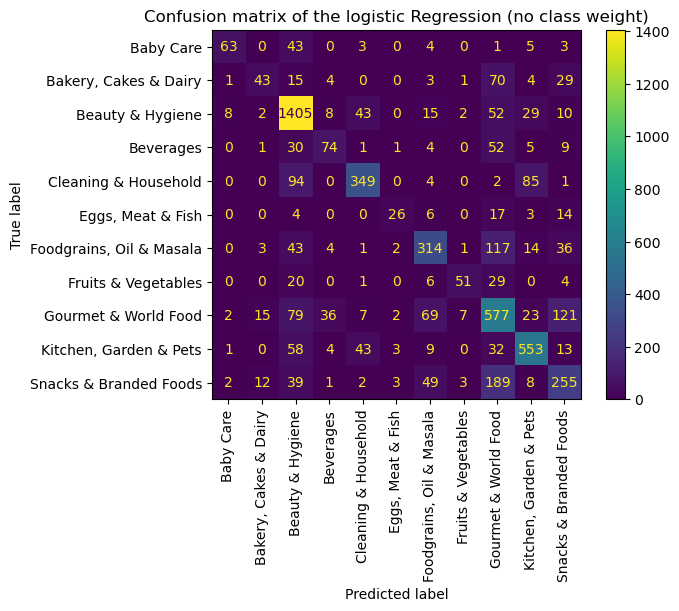

In [28]:
labels = le.inverse_transform(list(range(len(cluster_category))))
cm = confusion_matrix(y_true=y_test, y_pred=LR.predict(X_test),  labels=list(range(len(cluster_category))) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
disp.ax_.tick_params('x', labelrotation=90)
plt.title('Confusion matrix of the logistic Regression (no class weight)')
plt.show()

#### Logistic Regression with class weight

In [29]:
start = time.time()
#LR = LogisticRegression(max_iter=5000, class_weight = class_weight, n_jobs=-1).fit(X_train, y_train)
LR = LogisticRegression(max_iter=5000, class_weight = 'balanced', n_jobs=-1).fit(X_train, y_train)
end = time.time()

acc_LR = LR.score(X_test, y_test)
print("[Multi_class Logistic Regression (with class weight)]The test accuracy is", acc_LR)
print("[Multi_class Logistic Regression (with class weight)]The running time is", end-start, "seconds")

[Multi_class Logistic Regression (with class weight)]The test accuracy is 0.6405371076029759
[Multi_class Logistic Regression (with class weight)]The running time is 19.53212571144104 seconds


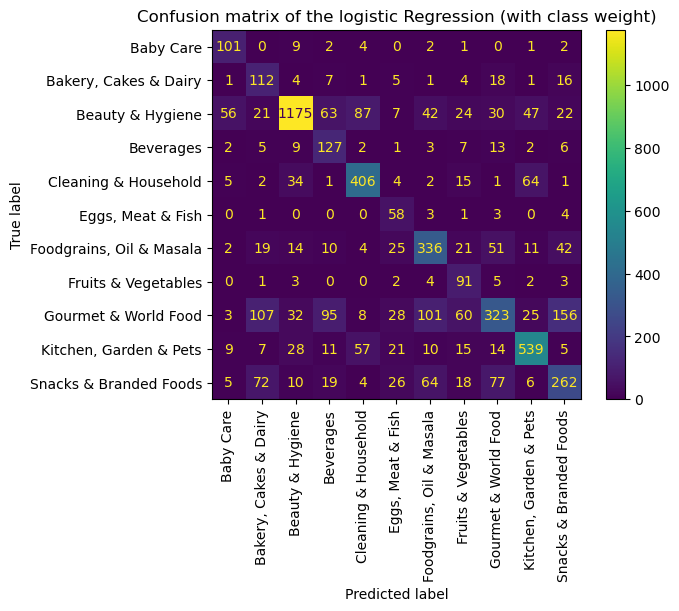

In [30]:
cm = confusion_matrix(y_true=y_test, y_pred=LR.predict(X_test),  labels=list(range(len(cluster_category))) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
disp.ax_.tick_params('x', labelrotation=90)
plt.title('Confusion matrix of the logistic Regression (with class weight)')
plt.show()

### b) Random Forest

#### Random forest without class weight

In [31]:
start = time.time()
RandomForest = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train, y_train)
end = time.time()

acc_RandomForest = RandomForest.score(X_test, y_test)
print("[Random Forest (no class weight)] The test accuracy is", acc_RandomForest)
print("[Random Forest (no class weight)] The running time is", end-start, "seconds")

[Random Forest (no class weight)] The test accuracy is 0.6824532752676465
[Random Forest (no class weight)] The running time is 131.21581768989563 seconds


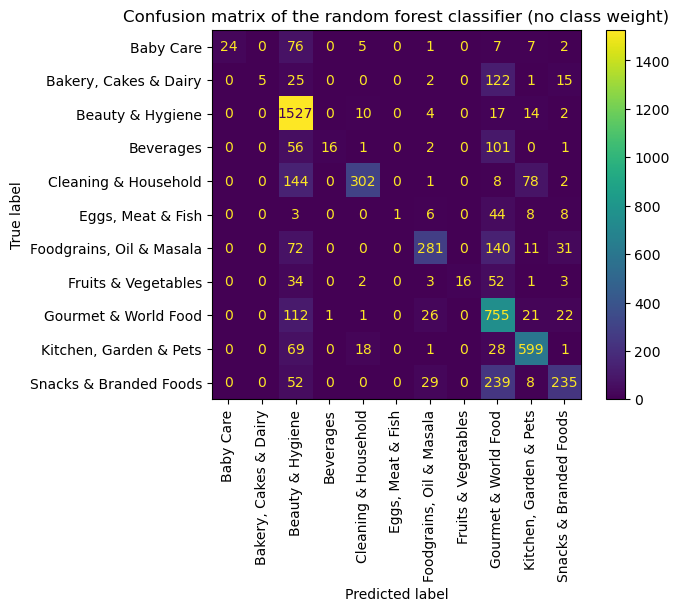

In [32]:
cm = confusion_matrix(y_true=y_test, y_pred=RandomForest.predict(X_test),  labels=list(range(len(cluster_category))) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
disp.ax_.tick_params('x', labelrotation=90)
plt.title('Confusion matrix of the random forest classifier (no class weight)')
plt.show()


#### Random forest with class weight

In [33]:
start = time.time()
RandomForest = RandomForestClassifier(n_estimators=500, class_weight = 'balanced', n_jobs=-1).fit(X_train, y_train)
end = time.time()

acc_RandomForest = RandomForest.score(X_test, y_test)
print("[Random Forest (with class weight)] The test accuracy is", acc_RandomForest)
print("[Random Forest (with class weight)] The running time is", end-start, "seconds")

[Random Forest (with class weight)] The test accuracy is 0.6706586826347305
[Random Forest (with class weight)] The running time is 137.3422224521637 seconds


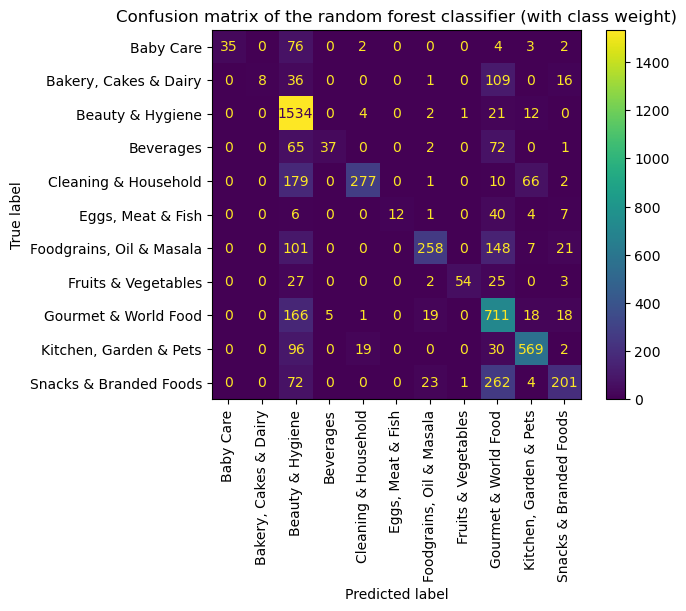

In [34]:
cm = confusion_matrix(y_true=y_test, y_pred=RandomForest.predict(X_test),  labels=list(range(len(cluster_category))) )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
disp.ax_.tick_params('x', labelrotation=90)
plt.title('Confusion matrix of the random forest classifier (with class weight)')
plt.show()

## 5. Results and Analysis

#### Summary table comparing supervised model and unsupervised model

|Mode type|Model|runing time(s)|test accuracy|runing time for best category matching(s)|
|-------|-------------|--------|--------|--------|
|Unsupervised Model|Hierarchical Clustering|220|0.2865|52327|
|Unsupervised Model|KMeans|14|0.2455|54321|
|Supervised Model|Multiclass Logistic Regression (no class weight)|18|0.6732|
|Supervised Model|Multiclass Logistic Regression (with class weight)|20|0.6405|
|Supervised Model|Random Forest (no class weight)|131|0.6825|
|Supervised Model|Random Forest (with class weight)|137|0.6707|

## 6. Discussion and Conclusion

In this project, my goal was to train unsupervised models to classify products into the correct category based on the product name and description. To do this, I built two unsupervised models (Hierarchical Clustering & K-means Clustering) and two supervised models (Multiclass Logistic Regression & Random Forest), and compared their performance. Here are some takeaways:
- From EDA, the data is imbalanced. But for unsupervised model training, we are not supposed to know the categories in advance, therefore I still use the original data to train unsupervised model.
- As for unsupervised models, unfortunately, neither the hierarchical clustering model nor the K-means clustering model works well with this data. One possible reason is that the product description does not contain enough or accurate information to suggest the product category.
- Besides, while the unsupervised model ran quickly and provided the clusters we needed, finding the best match between these clusters and the category names took an extremely long time. Considering that there are only 10 categories in this data, hand-engineering would be much efficient for cluster matching.
- For the supervised model, I added a class weight hyperparameter to try to offset the effect of data imbalance. However, the test accuracy did not improve significantly with class weight adjustment.